In [76]:
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [77]:
class model3():
    def __init__(self, max_iter=1000, tol=1e-8, learning_rate=0.01, reg = 10, stochastic=False, batch_size=32, epochs = 100):
        # Hyperparameters
        self.max_iter = max_iter
        self.tol = tol
        self.learning_rate = learning_rate
        self.stochastic = stochastic
        self.batch_size = batch_size
        self.epochs = epochs
        self.reg = reg

        # Variables to store
        self.X = None
        self.y = None
        self.n = None
        self.d = None
        self.weights = None
        self.classes = None
        self.num_classes = None
        self.y_dict = None
        self.one_hot = None
        self.differences = None
        self.class_index = []
        

    ############################## Helper Functions ###############################
    def label_from_stationary(self, stationary, show_probabilities = False):
        """Get the label from the stationary distribution
        Input:
            stationary (n,) ndarray - The stationary distribution of the data
        Output:
            labels (n,) ndarray - The predicted labels of the data"""
        
        # Check if the sum of the stationary distribution is approximately 1
        if not np.isclose(np.sum(stationary), 1):
            raise ValueError("The weights do not sum to 1.")
        
        # Sum the weights for each class
        class_probabilities = np.zeros(self.num_classes)
        for weight, label in zip(stationary, self.y):
            class_probabilities[self.y_dict[label]] += weight

        # Return the probabilities if requested
        if show_probabilities:
            return class_probabilities
        
        # Otherwise, return the class with the highest weight
        else:
            indices = np.argmax(class_probabilities)
            return self.classes[indices]
        
    def get_gaussian(self, weights):
        """ Get the gaussian kernel for the informative points
        Input:
            informative_points (n,d) ndarray - The informative points
            target (n,) ndarray - The target values
            weights (d,) ndarray - The weights for the informative points
        Output:
            gaussian (n,n) ndarray - The gaussian kernel for the informative points"""
        tensor_prod = np.einsum('ijk,lk->ijl', self.differences, weights)
        return np.exp(-np.linalg.norm(tensor_prod, axis=2)).T, tensor_prod
    

    def encode_y(self,y):
        # Check if the input is a list
        if isinstance(y, list):
            y = np.array(y)

        # Make sure it is a numpy array
        elif not isinstance(y, np.ndarray):
            raise ValueError("y must be a list or a numpy array")
        
        # If it is not integers, give it a dictionary
        if y.dtype != int:
            self.classes = np.unique(y)
            self.num_classes = len(self.classes)
            self.y_dict = {label: i for i, label in enumerate(np.unique(y))}

        # If it is, still make it a dictionary
        else:
            self.classes = np.arange(np.max(y)+1)
            self.num_classes = len(self.classes)
            self.y_dict = {i: i for i in self.classes}

        # Create an index array
        for i in range(self.num_classes):
            self.class_index.append(np.where(y == self.classes[i])[0])

        # Make a one hot encoding
        self.one_hot = np.zeros((self.n, self.num_classes))
        for i in range(self.n):
            self.one_hot[i, self.y_dict[y[i]]] = 1


    ############################## Training Functions ##############################
    def gradient(self, W):
        # Get the gaussian kernel, and tensor product
        gaussian, tensor_prod = self.get_gaussian(W) # - np.eye(self.n)
        dW = np.zeros((self.d,self.d))
        
        # Loop through the different classes and select the right subsets
        for i in range(len(self.classes)):
            g_c = gaussian[self.class_index[i]]
            g_c_totals = np.sum(g_c, axis=0)[:, np.newaxis, np.newaxis] + 1e-20
            product_c = tensor_prod[self.class_index[i]]
            differences_c = self.differences[self.class_index[i]]

            # Calculate the weighted products
            weighted_product_c = g_c[:,:,np.newaxis] * product_c
            weighted_sum_c = np.sum(np.einsum('ijk,ijl->ijkl', weighted_product_c, differences_c), axis = 0)
            weighted_sum_c /= g_c_totals

            # Calculate the gradient first term
            dW += np.sum(self.one_hot[:,i][:,np.newaxis, np.newaxis] * weighted_sum_c, axis=0)

        # Calculate the gradient first term
        g_all_totals = np.sum(gaussian, axis=0)[:, np.newaxis, np.newaxis] + 1e-20
        weighted_product_all = gaussian[:,:,np.newaxis] * tensor_prod
        weighted_sum_all = np.sum(np.einsum('ijk,ijl->ijkl', weighted_product_all, self.differences), axis = 0)
        weighted_sum_all /= g_all_totals

        # Calculate the gradient second term
        dW -= np.sum(weighted_sum_all, axis=0)

        # Return the regularized gradient
        return 2*dW + self.reg*W / np.linalg.norm(W, 'fro')

    def gradient_descent(self):
        for i in range(self.max_iter):
            # Get the gradient
            gradient = self.gradient(self.weights)
            self.weights -= self.learning_rate * gradient

            # Check if the gradient is below the tolerance
            if np.linalg.norm(gradient) < self.tol*self.n:
                break
            print(i, np.linalg.norm(gradient))

    def stochastic_gradient_descent(self):
        pass

    def fit(self, X, y):
        # Save the data as variables
        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.d = X.shape[1]
        self.weights = np.eye(self.d)
        self.encode_y(y)

        # Perform necessary calculations
        self.differences = self.X[:,np.newaxis,:] - self.X[np.newaxis,:,:]

        # If it is not stochastic, run the gradient descent
        if not self.stochastic:
            self.gradient_descent()

        # Otherwise, run the stochastic gradient descent
        else:
            self.stochastic_gradient_descent()

    

    ############################## Prediction Functions #############################
    def predict(self, points, show_probabilities=False):
        """Predict the labels of the data
        Input:
            points (n,d) ndarray - The data to predict
        Output:
            predictions (n,) ndarray - The predicted labels of the data"""
        # Check the shape of the data and the point and initialize the predictions
        if len(points.shape) == 1:
            points = points[np.newaxis,:]
        predictions = []

        # Get the differences array
        differences = self.X[:,np.newaxis,:] - points[np.newaxis,:,:]
        probs = np.exp(-np.linalg.norm(np.einsum('ijk,lk->ijl', differences, self.weights), axis=2)).T
        probs /= np.sum(probs, axis=1, keepdims=True)
        
        # Loop through the different points and get the predictions
        for i in range(points.shape[0]):
            predictions.append(self.label_from_stationary(probs[i], show_probabilities=show_probabilities))

        # Return the predictions
        return np.array(predictions)


    ############################## Analysis Functions ###############################

### 2D plotting functions

In [78]:
def show_probs(model, h = .05, x_size = [-3.5, 3.5], y_size = [-3.5, 3.5]):
    x_min, x_max = x_size[0], x_size[1]
    y_min, y_max = y_size[0], y_size[1]
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    predictions = model.predict(grid_points, show_probabilities=True)[:,1]
    Z = np.array(predictions).reshape(xx.shape)

    # Plot the decision boundary using a contour plot
    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm, levels = 100)
    level_set = plt.contour(xx, yy, Z, levels=[0.5], colors='grey', linestyles='dashed', linewidths=.5)
    plt.clabel(level_set)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, alpha = .5, s=10)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # plot a circle around the origin
    circle = plt.Circle((0, 0), 1, color='k', fill=False)
    plt.gca().add_artist(circle)
    plt.show()

    # Plot the 3d plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, 1-Z, cmap='coolwarm')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Probability of being in class 1')
    plt.show()

def plot_boundary(model, title, h = .05, x_size = [-3.5, 3.5], y_size = [-3.5, 3.5]):
    x_min, x_max = x_size[0], x_size[1]
    y_min, y_max = y_size[0], y_size[1]
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    predictions = model.predict(grid_points)
    Z = np.array(predictions).reshape(xx.shape)

    # Plot the decision boundary using a contour plot
    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, alpha = .5, s=10)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # plot a circle around the origin
    circle = plt.Circle((0, 0), 1, color='k', fill=False)
    plt.gca().add_artist(circle)
    plt.show()

    predictions_y = np.linalg.norm(grid_points, axis=1)>1
    print("Accuracy: ", accuracy_score(predictions, predictions_y))

/var/folders/t4/43zvz_r119l5fk_hdwn6_mbw0000gn/T/ipykernel_21078/1759266225.py:2: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X = np.random.multivariate_normal([0,0], np.array([[1,2],[2,1]]), 500)
/var/folders/t4/43zvz_r119l5fk_hdwn6_mbw0000gn/T/ipykernel_21078/1759266225.py:6: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  test = np.random.multivariate_normal([0,0], np.array([[1,2],[2,1]]), 100)


0 217.68574883315563
1 52.88155207284197
2 34.45566905079094
3 28.77486431703903
4 22.737355831223137
5 16.85987438043857
6 12.056996823020171
7 8.506707790469182
8 5.699868133839723
9 3.4552292575958554
10 1.8709900397148227
11 0.9227383287378642
12 0.42831473274897724
13 0.19234189424036358
14 0.08500065426174433
15 0.03728530639711539
16 0.016302089904603304
17 0.007116984971167302
18 0.003105224724422928
19 0.0013544078323288126
20 0.000590706661344623
21 0.00025760464237948406
22 0.00011234191336225248
23 4.899035744895362e-05
24 2.136441038562275e-05
25 9.31662698121491e-06
[[ 5.83791464e+00 -2.06854172e-02]
 [ 3.96258378e-03  5.90350461e+00]]


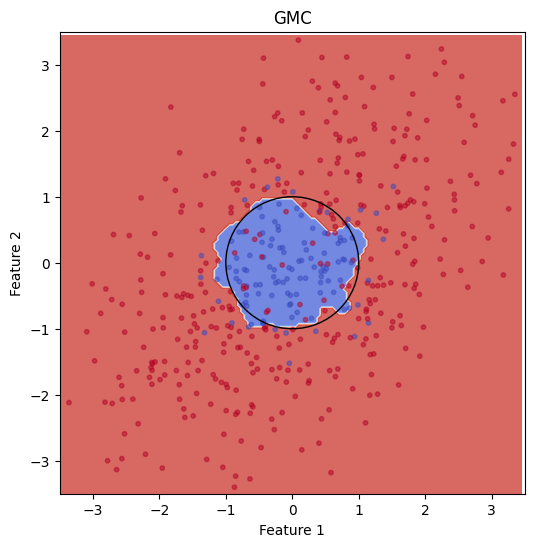

Accuracy:  0.9873469387755102


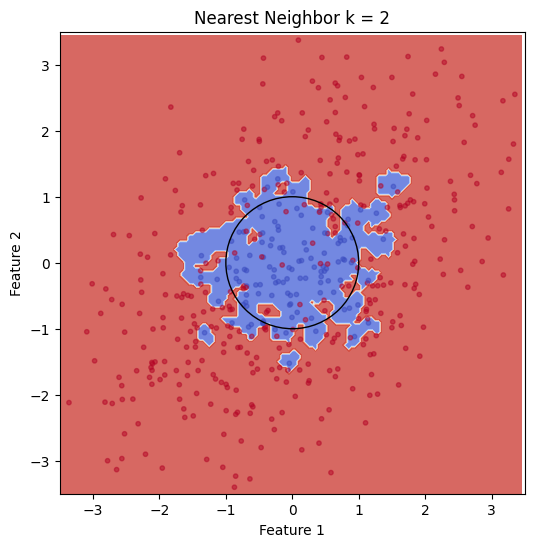

Accuracy:  0.9456632653061224


In [79]:
#np.random.seed(47)
X = np.random.multivariate_normal([0,0], np.array([[1,2],[2,1]]), 500)
y = np.linalg.norm(X, axis=1)>1
X += np.random.normal(0, .4, X.shape)

test = np.random.multivariate_normal([0,0], np.array([[1,2],[2,1]]), 100)
test_y = np.linalg.norm(test, axis=1)>1

model = model3(learning_rate=.1, reg = 50)
model.fit(X, y)
# print("begin prediction")
# predictions = model.predict(test)
print(model.weights)
# print(accuracy_score(predictions, test_y))

# nearest neighbor
from sklearn.neighbors import KNeighborsClassifier
neighbors = 2
knn = KNeighborsClassifier(n_neighbors= neighbors)
knn.fit(X, y)

plot_boundary(model, "GMC", h=.05, x_size = [-3.5, 3.5], y_size = [-3.5, 3.5])
plot_boundary(knn, f"Nearest Neighbor k = {neighbors}",h = .05, x_size = [-3.5, 3.5], y_size = [-3.5, 3.5])

In [81]:
# load digits dataset
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

# randomly choose a subset of the data
np.random.seed(47)
indices = np.random.choice(X_train.shape[0], 100, replace=False)
X_train = X_train[indices]
y_train = y_train[indices]
model = model3(learning_rate=.1, reg = 1)
model.fit(X_train, y_train)
print(model.weights)
gmc_predictions = model.predict(X_test)
print(accuracy_score(gmc_predictions, y_test))

# nearest neighbor
neighbors = 2
knn = KNeighborsClassifier(n_neighbors= neighbors)
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)
print(accuracy_score(knn_predictions, y_test))

# confusion matrix
confusion_matrix(y_test, gmc_predictions)
confusion_matrix(y_test, knn_predictions)



0 0.9999999949986429
1 0.9999999931153056
2 0.9999999905188068
3 0.9999999869372613
4 0.9999999819942815
5 0.9999999751684189
6 0.9999999657366829
7 0.9999999526957983
8 0.9999999346523137
9 0.9999999096690416
10 0.9999998750502338
11 0.9999998270406347
12 0.9999997604033335
13 0.9999996678267439
14 0.9999995390903201
15 0.9999993598890183
16 0.9999991101742342
17 0.9999987618083859
18 0.9999982752433776
19 0.999997594808113
20 0.9999966420100116
21 0.9999953059949646
22 0.9999934299330823
23 0.9999907915502417
24 0.9999870752294795
25 0.9999818319462569
26 0.9999744216077636
27 0.999963929889012
28 0.9999490480297475
29 0.9999278987366504
30 0.9998977835350877
31 0.9998548154861259
32 0.9997933844767032
33 0.9997053779714976
34 0.9995790449828946
35 0.999397340896923
36 0.9991355207574993
37 0.9987576540902705
38 0.9982116144641152
39 0.9974219629401325
40 0.996280038851931
41 0.994630608919149
42 0.992254874989924
43 0.9888510655438865
44 0.9840172860564741
45 0.9772483736413801
46 0

array([[32,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 33,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  2, 33,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2, 27,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 45,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  4,  0, 36,  0,  1,  1,  0],
       [ 0,  1,  0,  0,  1,  0, 40,  0,  0,  0],
       [ 0,  2,  0,  0,  1,  0,  0, 26,  0,  0],
       [ 0,  6,  2,  4,  0,  0,  1,  1, 22,  0],
       [ 1,  2,  0, 10,  0,  2,  0,  0,  1, 19]])

In [82]:
# import random forest and xgboost for benchmarking
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# random forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)
print(accuracy_score(rf_predictions, y_test))

# xgboost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_predictions = xgb.predict(X_test)
print(accuracy_score(xgb_predictions, y_test))
confusion_matrix(y_test, xgb_predictions)
confusion_matrix(y_test, rf_predictions)

0.8444444444444444
0.7888888888888889


array([[32,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 32,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 1,  3, 29,  2,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0, 27,  0,  0,  0,  0,  2,  0],
       [ 0,  1,  0,  0, 42,  0,  0,  2,  0,  0],
       [ 0,  2,  0,  6,  0, 34,  0,  0,  0,  1],
       [ 0,  2,  0,  0,  1,  0, 39,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0, 28,  0,  0],
       [ 0,  5,  0,  2,  2,  1,  0,  1, 25,  0],
       [ 1,  0,  0, 14,  1,  3,  0,  0,  0, 16]])